In [22]:
import random
import cv2 as cv
import numpy as np
import tensorflow as tf

import imgaug as ia
import imgaug.augmenters as iaa

from numpy.linalg import inv
from matplotlib import pyplot as plt
from PIL import Image

In [23]:
def show_image(location, title, img, width=None):
    if width is not None:
        plt.figure(figsize=(width, width))
    plt.subplot(*location)
    plt.title(title, fontsize=8)
    plt.axis('off')
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')
    if width is not None:
        plt.show()
        plt.close()

In [24]:
def perturbed_image(image):
    
    bet1 = np.random.randint(1, 10)
    
    if bet1%2 == 0:
        print("Contrast")
        image = contrast(image)
    else:
        print("Hsv")
        image = Hsv(image)
        
    bet2 = np.random.randint(1,10)
    
    if bet2%2 == 0:
        print("Motion")
        image = Motion_blur(image)
    else:
        print("Gaussian")
        image = Gaussian_blur(image)
    
    return image

In [25]:
def contrast(image):
    alpha = random.uniform(0.8, 1.2)

    if alpha< 1:
        beta = random.randint(-20, 0)
    if alpha > 1:
        beta = random.randint(0, 20)
    
    rows, cols, channels = image.shape

    blank = np.zeros([rows, cols, channels], image.dtype)
    dst = cv.addWeighted(image, alpha, blank, 1-alpha, beta )
    
    return dst

def Hsv(image):
    hue_vari = 1
    sat_vari = 0.5
    val_vari = 0.5
    hue_delta = np.random.randint(-hue_vari, hue_vari)
    sat_mult = 1 + np.random.uniform(-sat_vari, sat_vari)
    val_mult = 1 + np.random.uniform(-val_vari, val_vari)

    img_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV).astype(np.float)
    img_hsv[:, :, 0] = (img_hsv[:, :, 0] + hue_delta) % 180
    img_hsv[:, :, 1] *= sat_mult
    img_hsv[:, :, 2] *= val_mult
    img_hsv[img_hsv > 255] = 255
    
    dst = cv.cvtColor(np.round(img_hsv).astype(np.uint8), cv.COLOR_HSV2BGR)
    return dst

def Gamma(image):
    gamma_vari = 0.1
    log_gamma_vari = np.log(gamma_vari)
    alpha = np.random.uniform(-log_gamma_vari, log_gamma_vari)
    gamma = np.exp(alpha)
    gamma_table = [np.power(x / 255.0, gamma) * 255.0 for x in range(256)]
    gamma_table = np.round(np.array(gamma_table)).astype(np.uint8)
    dst = cv.LUT(image, gamma_table)
    return dst


def Motion_blur(image):
    image = np.array(image)
    degree_ = 20
    angle_ = 45
    degree = int(np.random.uniform(1, degree_))
    angle = int(np.random.uniform(-angle_, angle_))
    M = cv.getRotationMatrix2D((degree / 2, degree / 2), angle, 1)
    motion_blur_kernel = np.diag(np.ones(degree))
    motion_blur_kernel = cv.warpAffine(motion_blur_kernel, M, (degree, degree))
    motion_blur_kernel = motion_blur_kernel / degree
    blurred = cv.filter2D(image, -1, motion_blur_kernel)
    cv.normalize(blurred, blurred, 0, 255, cv.NORM_MINMAX)
    dst = np.array(blurred, dtype=np.uint8)
    return dst

def Gaussian_blur(image):

    kernel = [random.randint(1, 3) * 2 + 1 for x in range(1)]
    dst = cv.GaussianBlur(image, ksize=(kernel[0], kernel[0]), sigmaX=0, sigmaY=0)
    return dst

In [26]:
size = (320, 240)
rho = 128
patch_size = 128

img = cv.imread("C:/Users/xwen2/Desktop/1.jpg")
img = img[:,:, (2, 1, 0)]
img = cv.resize(img, size)

new_image = perturbed_image(img)

Contrast
Gaussian


In [27]:
#top_point = (96,56) #(rho, rho)
#top_point = (224,56)
#top_point = (96,103)
#top_point = (224,56)
#top_point = (160,80)
top_point = (32, 80)

left_point = (top_point[0], patch_size + top_point[1])
bottom_point = (patch_size + top_point[0], patch_size + top_point[1])
right_point = (patch_size + top_point[0], top_point[1])

four_points = [top_point, left_point, bottom_point, right_point]

In [28]:
perturbed_four_points = []
flag = 0
for point in four_points:
    #perturbed_four_points.append((point[0] + random.randint(-rho, +rho), point[1] + random.randint(-rho, +rho)))
    
    if (flag == 0):
        perturbed_four_points.append((point[0] + random.randint(-rho, 0), point[1] + random.randint(-rho, 0)))
    elif(flag == 1):
        perturbed_four_points.append((point[0] + random.randint(-rho, 0), point[1] + random.randint(0, +rho)))
    elif(flag == 2):
        perturbed_four_points.append((point[0] + random.randint(0, +rho), point[1] + random.randint(0, +rho)))
    elif(flag == 3):
        perturbed_four_points.append((point[0] + random.randint(0, +rho), point[1] + random.randint(-rho, 0)))
    flag = flag + 1

In [29]:
print("four_points: ", four_points)
print("perturbed_points: ", perturbed_four_points)
a = tf.reshape( four_points, [1, -1] )
b = tf.reshape( perturbed_four_points, [1, -1] )
c = a - b
with tf.Session():
    print("delta_points: ", c) 
    print("delta_points: ", c.eval())

four_points:  [(32, 80), (32, 208), (160, 208), (160, 80)]
perturbed_points:  [(-37, 59), (-6, 307), (189, 290), (285, 56)]
delta_points:  Tensor("sub_1:0", shape=(1, 8), dtype=int32)
delta_points:  [[  69   21   38  -99  -29  -82 -125   24]]


In [30]:
H = cv.getPerspectiveTransform(np.float32(four_points), np.float32(perturbed_four_points))
H_inverse = inv(H)
print("Transformation: \n", H_inverse)

Transformation: 
 [[ 1.84207933e-01 -5.13788101e-02  2.68383611e+01]
 [-1.23421777e-02  9.13029650e-02  3.66347590e+01]
 [-1.72963794e-04 -8.64405102e-04  5.75578921e-01]]


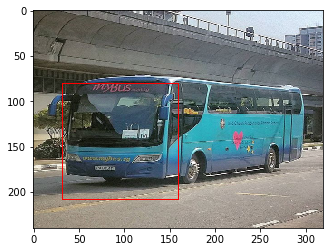

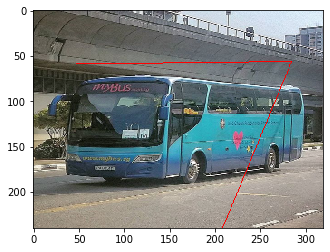

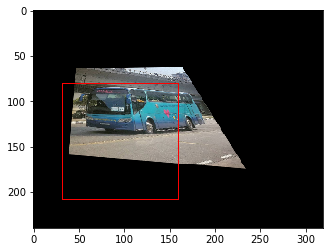

In [31]:
dst_image = img.copy()
src_image = img.copy()
warped_image = cv.warpPerspective(img, H_inverse, size)

cv.polylines(src_image, np.int32([four_points]),           200, (255,0,0))
cv.polylines(dst_image, np.int32([perturbed_four_points]), 200, (255,0,0))
cv.polylines(warped_image, np.int32([four_points]),        200, (255,0,0))

plt.imshow( src_image)
plt.show()
plt.imshow( dst_image)
plt.show()
plt.imshow( warped_image)
plt.show()

In [32]:
Ip1 = img[top_point[1]:bottom_point[1], top_point[0]:bottom_point[0]]
Ip2 = warped_image[top_point[1]:bottom_point[1], top_point[0]:bottom_point[0]]

In [33]:
Ip1 = cv.cvtColor(Ip1, cv.COLOR_BGR2GRAY)
Ip2 = cv.cvtColor(Ip2, cv.COLOR_BGR2GRAY)

Ip1 image size:  16384
Ip2 image size:  16384
Input image size:  32768


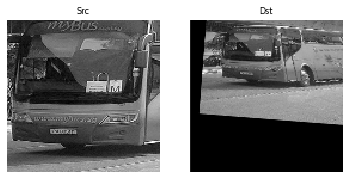

In [34]:
training_image = np.dstack((Ip1, Ip2))
print("Ip1 image size: ", Ip1.size) # 256*256
print("Ip2 image size: ", Ip2.size) # 256*256

print("Input image size: ", training_image.size)
show_image((1,2,1), "Src", Ip1)
show_image((1,2,2), "Dst", Ip2)
plt.show()

In [20]:
training_image = np.dstack((Ip1, Ip2))

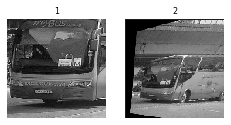

In [21]:
show_image((1,3,1), "1", training_image[:,:,0])#img[0, :, :])
show_image((1,3,2), "2", training_image[:,:,1])#img[1, :, :])
plt.show()

In [110]:
im_size = 128

img0 = training_image[:, :, 0]
img0 = cv.resize(img0, (im_size, im_size))

img1 = training_image[:, :, 1]
img1 = cv.resize(img1, (im_size, im_size))

img = np.zeros((im_size, im_size, 3), np.float32)

img[:, :, 0] = img0 / 255.
img[:, :, 1] = img1 / 255.



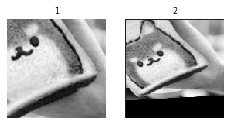

In [111]:
show_image((1,3,1), "1", img0)#img[0, :, :])
show_image((1,3,2), "2", img1)#img[1, :, :])
#show_image((1,3,3), "3", img[2, :, :])
plt.show()

In [112]:
H_four_points = np.subtract(np.array(perturbed_four_points), np.array(four_points))
print("sub-four-points: \n")
print(H_four_points)

sub-four-points: 

[[ -13  -53]
 [-101  118]
 [  31  117]
 [   4  -10]]


In [37]:
target = np.reshape(H_four_points, (8,))
print("target: ", target)

target:  [-87 -91 -55  19  75  79  31 -29]
